In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import cbmos_serial as cbmos
import force_functions as ff
import euler_forward as ef
import adams_bashforth as ab
import midpoint as md
import heun as he
import cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
          'legend.fontsize': 'xx-large',
         'font.size': 11,
          'font.family': 'serif',
          "mathtext.fontset": "dejavuserif",
         'axes.titlepad': 12,
        'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
# calculate radius
def calculate_radius(cell_list):
    n_cells = len(cell_list)
    positions = np.array([cell.position for cell in cell_list])
    c = np.sum(positions, axis=0)/n_cells
    return 0.5 + max([np.linalg.norm(cell.position - c) for cell in cell_list])

In [3]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance
dim = 2
seed=67
t_data = np.linspace(0, tf, int(100*tf)+1)
n = 10

In [4]:
#solver_names = ['EF', 'AB', 'midpoint', 'Heun']
#force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6], 'GLS sc': 'black'}
linestyles = {'cubic': '-', 'pw. quad.': '--', 'GLS': '-.', 'GLS sc': ':'}
labels = {'cubic': 'cubic', 'pw. quad.': 'pw. quad.', 'GLS': r'GLS, $\alpha^{(1)}$', 'GLS sc': r'GLS, $\alpha^{(2)}$'}

In [5]:
# Solvers
solvers_scpi = {'pw. quad.': cbmos.CBMSolver(ff.piecewise_polynomial, scpi.solve_ivp, dim), 
             'cubic': cbmos.CBMSolver(ff.cubic, scpi.solve_ivp, dim),
             'GLS': cbmos.CBMSolver(ff.gls, scpi.solve_ivp, dim),
               'GLS sc': cbmos.CBMSolver(ff.gls, scpi.solve_ivp, dim)}

## Initial configurations with 19 and 37 cells

In [6]:
# 2D honeycomb mesh with 19 cells
n_x = 5
n_y = 5
xcrds = [(2 * i + (j % 2)) * 0.5 for j in range(n_y) for i in range(n_x)]
ycrds = [np.sqrt(3) * j * 0.5 for j in range(n_y) for i in range(n_x)]

# make cell_list for the sheet
initial_sheet_19 = [cl.Cell(i, [x,y], -24.0, True, lambda t: 24+t) for i, x, y in zip(range(n_x*n_y), xcrds, ycrds)]
# delete cells to make it circular
del initial_sheet_19[24]
del initial_sheet_19[20]
del initial_sheet_19[19]
del initial_sheet_19[9]
del initial_sheet_19[4]
del initial_sheet_19[0]

In [7]:
# 2D honeycomb mesh with 37 cells
n_x = 7
n_y = 7
xcrds = [(2 * i + (j % 2)) * 0.5 for j in range(n_y) for i in range(n_x)]
ycrds = [np.sqrt(3) * j * 0.5 for j in range(n_y) for i in range(n_x)]

# make cell_list for the sheet
initial_sheet_37 = [cl.Cell(i, [x,y], -24.0, True, lambda t: 24+t) for i, x, y in zip(range(n_x*n_y), xcrds, ycrds)]

# delete cells to make it circular
del initial_sheet_37[48]
del initial_sheet_37[43]
del initial_sheet_37[42]
del initial_sheet_37[41]
del initial_sheet_37[35]
del initial_sheet_37[28]
del initial_sheet_37[14]
del initial_sheet_37[13]
del initial_sheet_37[7]
del initial_sheet_37[6]
del initial_sheet_37[1]
del initial_sheet_37[0]

## Parameters for the different fitting strategies

In [8]:
# parameters
## fit to relaxation time
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls = 1.95
params_gls_sc = {'mu': 1.95, 'a':-2*np.log(0.002/mu_gls)}
params_gls = {'mu': 1.95, 'a': 7.51}
params_relax = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls, 'GLS sc': params_gls_sc}

## fit to complete range
muR = 11.33 #1.13328915e+01
ratio = 0.002 #2.14391581e-03
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
params_gls = {'mu': 4.27, 'a': 11.41 }
params_gls_sc = {'mu': 4.27, 'a':-2*np.log(0.002/mu_gls)}
params_complete = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls, 'GLS sc': params_gls_sc}


## fit to repulsive range
muR = 11.35 # 1.13496715e+01
ratio = 0.002 # 1.79125464e-03
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls = 4.27
params_gls_sc = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params_gls = {'mu': mu_gls, 'a': 11.41}

params_repulsive = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls, 'GLS sc': params_gls_sc}

## fit to adhesive range
muR = 8.13#8.13262893
ratio =0.46# 0.46188714
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
params_gls_sc = {'mu': 4.43, 'a':-2*np.log(0.002/mu_gls)}
params_gls = {'mu': 2.18, 'a': 7.95}
params_adhesive = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls, 'GLS sc': params_gls_sc}

## fit to population radius
muR = 9.76
ratio = 0.26
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
params_gls_sc = {'mu': 2.28, 'a':-2*np.log(0.002/mu_gls)}
#params_gls = {'mu': 1.83, 'a': 10.93}
params_gls = {'mu': 2.40, 'a': 6.64} 
params_population = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls, 'GLS sc': params_gls_sc}

params = {'relax': params_relax, 
          'complete': params_complete, 
          'repulsive': params_repulsive, 
          'adhesive': params_adhesive,
          'population': params_population}

## Calculate the population radii

In [9]:
solver_scipy = cbmos.CBMSolver(ff.piecewise_polynomial, scpi.solve_ivp, dim)
#solver_scipy = cbmos.CBMSolver(ff.cubic, scpi.solve_ivp, dim)
t_data_init = [0, 0.00001]

In [10]:
force_names = ['pw. quad.', 'GLS', 'GLS sc']


### 19 cells

In [11]:
radii_relax_19 = {'cubic': np.zeros(len(t_data)), 'pw. quad.': np.zeros(len(t_data)), 'GLS': np.zeros(len(t_data)), 'GLS sc': np.zeros(len(t_data))}
        
for a in range(0,n):
    sheet = solver_scipy.simulate(initial_sheet_19, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=a, raw_t=False)[-1]
      
    for force in ['cubic', 'pw. quad.', 'GLS', 'GLS sc']:
        history = solvers_scpi[force].simulate(sheet, t_data, params_relax[force], {}, seed=a, raw_t=False)
        radii_relax_19[force] = radii_relax_19[force] + np.array([calculate_radius(cl) for cl in history])

for force in ['cubic', 'pw. quad.', 'GLS', 'GLS sc']:
    radii_relax_19[force] = radii_relax_19[force]/n

In [12]:
radii_cubic_19 = radii_relax_19['cubic']

In [13]:
radii_complete_19 = {'pw. quad.': np.zeros(len(t_data)), 'GLS': np.zeros(len(t_data)), 'GLS sc': np.zeros(len(t_data))}
        
for a in range(0,n):
    sheet = solver_scipy.simulate(initial_sheet_19, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=a, raw_t=False)[-1]
      
    for force in force_names:
        history = solvers_scpi[force].simulate(sheet, t_data, params_complete[force], {}, seed=a, raw_t=False)
        radii_complete_19[force] = radii_complete_19[force] + np.array([calculate_radius(cl) for cl in history])

for force in force_names:
    radii_complete_19[force] = radii_complete_19[force]/n

In [14]:
radii_repulsive_19 = {'pw. quad.': np.zeros(len(t_data)), 'GLS': np.zeros(len(t_data)), 'GLS sc': np.zeros(len(t_data))}
        
for a in range(0,n):
    sheet = solver_scipy.simulate(initial_sheet_19, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=a, raw_t=False)[-1]
      
    for force in force_names:
        history = solvers_scpi[force].simulate(sheet, t_data, params_repulsive[force], {}, seed=a, raw_t=False)
        radii_repulsive_19[force] = radii_repulsive_19[force] + np.array([calculate_radius(cl) for cl in history])

for force in force_names:
    radii_repulsive_19[force] = radii_repulsive_19[force]/n

In [15]:
radii_adhesive_19 = {'pw. quad.': np.zeros(len(t_data)), 'GLS': np.zeros(len(t_data)), 'GLS sc': np.zeros(len(t_data))}
        
for a in range(0,n):
    sheet = solver_scipy.simulate(initial_sheet_19, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=a, raw_t=False)[-1]
      
    for force in force_names:
        history = solvers_scpi[force].simulate(sheet, t_data, params_adhesive[force], {}, seed=a, raw_t=False)
        radii_adhesive_19[force] = radii_adhesive_19[force] + np.array([calculate_radius(cl) for cl in history])

for force in force_names:
    radii_adhesive_19[force] = radii_adhesive_19[force]/n

In [16]:
radii_population_19 = {'pw. quad.': np.zeros(len(t_data)), 'GLS': np.zeros(len(t_data)), 'GLS sc': np.zeros(len(t_data))}
        
for a in range(0,n):
    sheet = solver_scipy.simulate(initial_sheet_19, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=a, raw_t=False)[-1]
      
    for force in force_names:
        history = solvers_scpi[force].simulate(sheet, t_data, params_population[force], {}, seed=a, raw_t=False)
        radii_population_19[force] = radii_population_19[force] + np.array([calculate_radius(cl) for cl in history])

for force in force_names:
    radii_population_19[force] = radii_population_19[force]/n

### 37 cells

In [17]:
radii_relax_37 = {'cubic': np.zeros(len(t_data)), 'pw. quad.': np.zeros(len(t_data)), 'GLS': np.zeros(len(t_data)), 'GLS sc': np.zeros(len(t_data))}
        
for a in range(0,n):
    sheet = solver_scipy.simulate(initial_sheet_37, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=a, raw_t=False)[-1]
      
    for force in ['cubic', 'pw. quad.', 'GLS', 'GLS sc']:
        history = solvers_scpi[force].simulate(sheet, t_data, params_relax[force], {}, seed=a, raw_t=False)
        radii_relax_37[force] = radii_relax_37[force] + np.array([calculate_radius(cl) for cl in history])

for force in ['cubic', 'pw. quad.', 'GLS', 'GLS sc']:
    radii_relax_37[force] = radii_relax_37[force]/n

In [18]:
radii_cubic_37 = radii_relax_37['cubic']

In [19]:
radii_complete_37 = {'pw. quad.': np.zeros(len(t_data)), 'GLS': np.zeros(len(t_data)), 'GLS sc': np.zeros(len(t_data))}
        
for a in range(0,n):
    sheet = solver_scipy.simulate(initial_sheet_37, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=a, raw_t=False)[-1]
      
    for force in force_names:
        history = solvers_scpi[force].simulate(sheet, t_data, params_complete[force], {}, seed=a, raw_t=False)
        radii_complete_37[force] = radii_complete_37[force] + np.array([calculate_radius(cl) for cl in history])

for force in force_names:
    radii_complete_37[force] = radii_complete_37[force]/n

In [20]:
radii_repulsive_37 = {'pw. quad.': np.zeros(len(t_data)), 'GLS': np.zeros(len(t_data)), 'GLS sc': np.zeros(len(t_data))}
        
for a in range(0,n):
    sheet = solver_scipy.simulate(initial_sheet_37, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=a, raw_t=False)[-1]
      
    for force in force_names:
        history = solvers_scpi[force].simulate(sheet, t_data, params_repulsive[force], {}, seed=a, raw_t=False)
        radii_repulsive_37[force] = radii_repulsive_37[force] + np.array([calculate_radius(cl) for cl in history])

for force in force_names:
    radii_repulsive_37[force] = radii_repulsive_37[force]/n

In [21]:
radii_adhesive_37 = {'pw. quad.': np.zeros(len(t_data)), 'GLS': np.zeros(len(t_data)), 'GLS sc': np.zeros(len(t_data))}
        
for a in range(0,n):
    sheet = solver_scipy.simulate(initial_sheet_37, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=a, raw_t=False)[-1]
      
    for force in force_names:
        history = solvers_scpi[force].simulate(sheet, t_data, params_adhesive[force], {}, seed=a, raw_t=False)
        radii_adhesive_37[force] = radii_adhesive_37[force] + np.array([calculate_radius(cl) for cl in history])

for force in force_names:
    radii_adhesive_37[force] = radii_adhesive_37[force]/n

In [22]:
radii_population_37 = {'pw. quad.': np.zeros(len(t_data)), 'GLS': np.zeros(len(t_data)), 'GLS sc': np.zeros(len(t_data))}
        
for a in range(0,n):
    sheet = solver_scipy.simulate(initial_sheet_37, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=a, raw_t=False)[-1]
      
    for force in force_names:
        history = solvers_scpi[force].simulate(sheet, t_data, params_population[force], {}, seed=a, raw_t=False)
        radii_population_37[force] = radii_population_37[force] + np.array([calculate_radius(cl) for cl in history])

for force in force_names:
    radii_population_37[force] = radii_population_37[force]/n

## Assemble the plot

In [23]:
r_val = np.linspace(0.3, 1.6, 1001)
forces = {'cubic': ff.cubic, 'pw. quad.': ff.piecewise_polynomial, 'GLS': ff.gls, 'GLS sc': ff.gls}

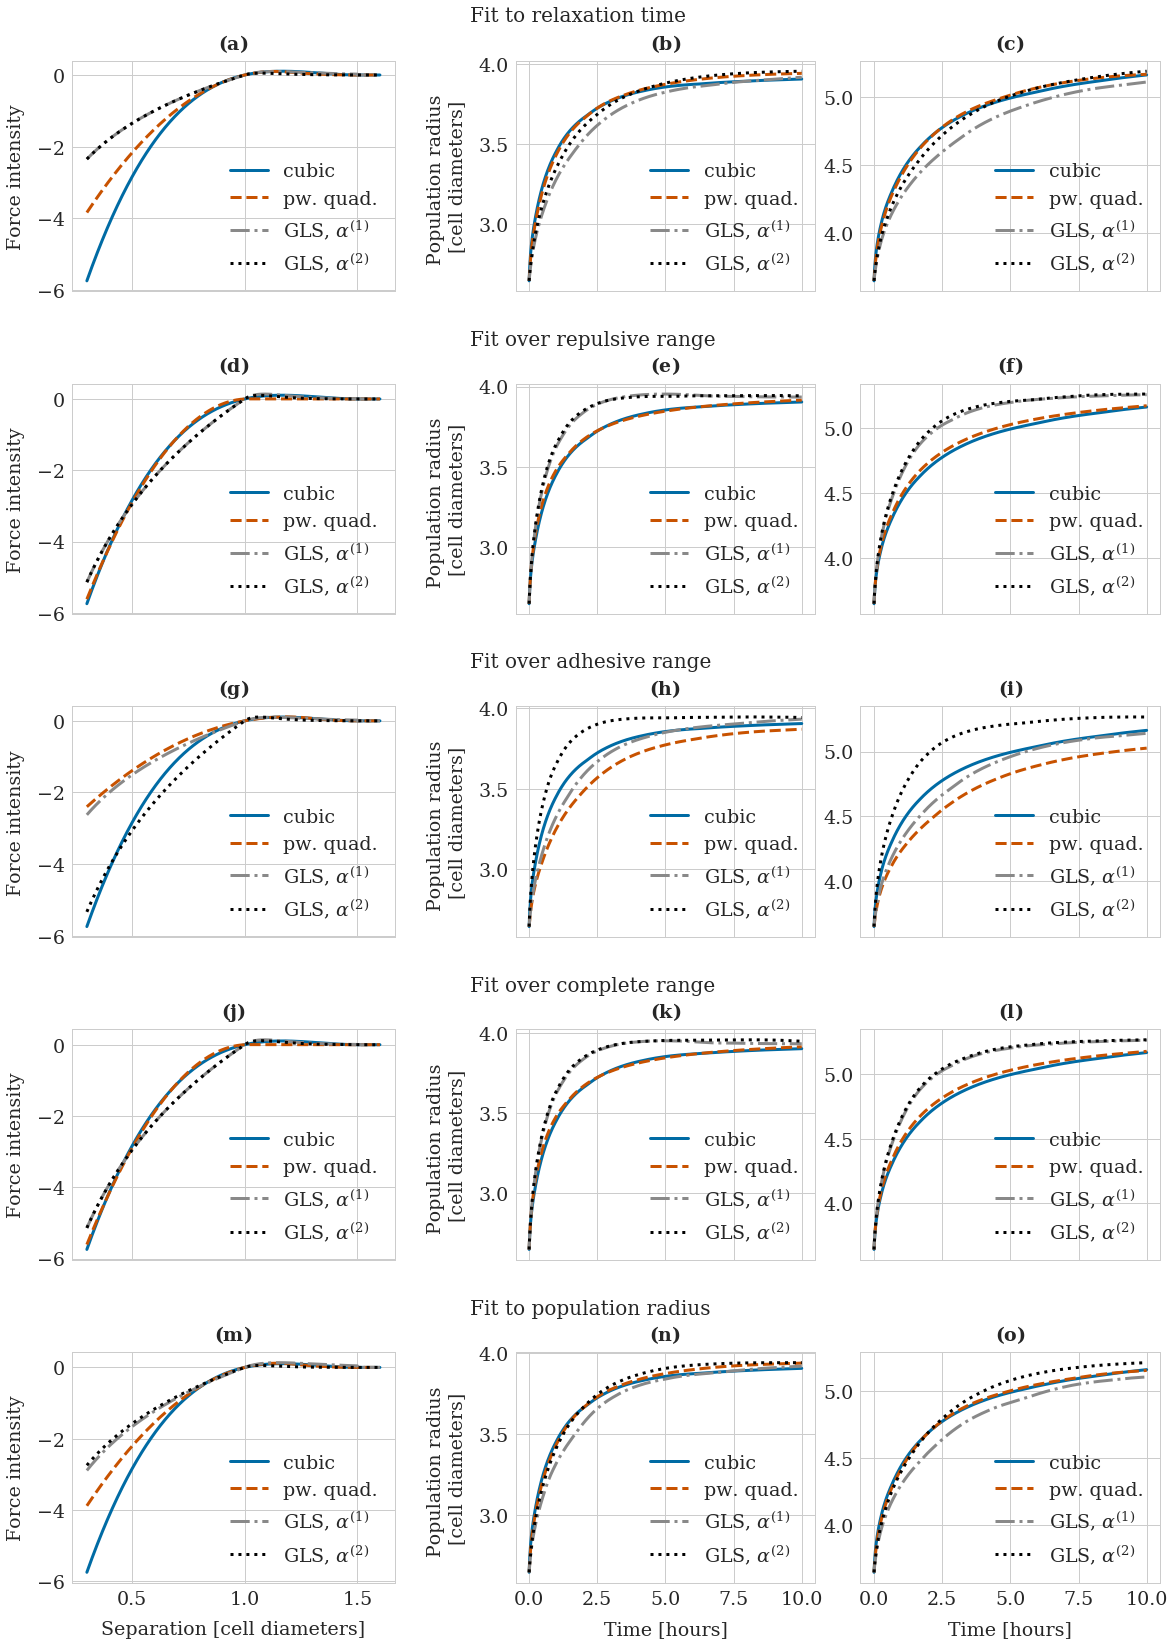

In [38]:
#fig, ((ax1, ax2, ax3),(ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), (ax13, ax14, ax15)) = plt.subplots(5,3, figsize=(19.5,25), sharex='col')
import matplotlib.gridspec as gridspec

outer = gridspec.GridSpec(1, 2, width_ratios=[1, 2], wspace=0.25)

gsleft = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=outer[0,0], hspace=0.4)
gsright = gridspec.GridSpecFromSubplotSpec(5, 2, subplot_spec=outer[0,1], wspace=0.15, hspace=0.4)

fig = plt.figure(figsize=(19.5,28))

ax1 = fig.add_subplot(gsleft[0,0])
ax4 = fig.add_subplot(gsleft[1,0])
ax7 = fig.add_subplot(gsleft[2,0])
ax10 = fig.add_subplot(gsleft[3,0])
ax13 = fig.add_subplot(gsleft[4,0])

ax2 = fig.add_subplot(gsright[0,0])
ax5 = fig.add_subplot(gsright[1,0])
ax8 = fig.add_subplot(gsright[2,0])
ax11 = fig.add_subplot(gsright[3,0])
ax14 = fig.add_subplot(gsright[4,0])

ax3 = fig.add_subplot(gsright[0,1])
ax6 = fig.add_subplot(gsright[1,1])
ax9 = fig.add_subplot(gsright[2,1])
ax12 = fig.add_subplot(gsright[3,1])
ax15 = fig.add_subplot(gsright[4,1])


#ax3._shared_y_axes.join(ax3, ax2)
#ax6._shared_y_axes.join(ax6, ax5)
#ax9._shared_y_axes.join(ax9, ax8)
#ax12._shared_y_axes.join(ax12, ax11)
#ax15._shared_y_axes.join(ax15, ax14)

#for ax in [ax3, ax6, ax9, ax12, ax15]:
#    ax.yaxis.set_tick_params(which='both', labelleft=False, labelright=False)
#    ax.yaxis.offsetText.set_visible(False)

for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]:
    ax.xaxis.set_tick_params(which='both', labelleft=False, labelright=False)
    ax.xaxis.offsetText.set_visible(False)

# first row: fit to relaxation time
## ax1
for force in ['cubic', 'pw. quad.', 'GLS', 'GLS sc']:
    ax1.plot(r_val, forces[force](r_val, **params_relax[force]), label=labels[force], color=colors[force], linestyle=linestyles[force])
ax1.set(ylabel='Force intensity')
ax1.legend()
#ax1.set_title(r'$\bf{(a)}$' ' Fit to relaxation time: \n Force intensities')
ax1.set_title(r'$\bf{(a)}$')

ax1.text(2, 1.5, r'Fit to relaxation time', fontsize=20)


## ax2 
for force in ['cubic', 'pw. quad.', 'GLS', 'GLS sc']: 
    ax2.plot(t_data, np.squeeze(radii_relax_19[force]), label=labels[force], color=colors[force], linestyle=linestyles[force])
ax2.set(ylabel='Population radius \n[cell diameters]')
ax2.set_yticks(np.arange(3.0, 4.5, 0.5))
ax2.legend()
#ax2.set_title(r'$\bf{(b)}$' ' Fit to relaxation time: \n Population radius for 38 cells')
ax2.set_title(r'$\bf{(b)}$')

## ax3
for force in ['cubic', 'pw. quad.', 'GLS', 'GLS sc']: 
    ax3.plot(t_data, np.squeeze(radii_relax_37[force]), label=labels[force], color=colors[force], linestyle=linestyles[force])
#ax3.set(ylabel='Population radius \n[cell diameters]')
ax3.legend()
#ax3.set_title(r'$\bf{(c)}$' ' Fit to relaxation time: \n Population radius for 74 cells')
ax3.set_title(r'$\bf{(c)}$')


# second row: fit to repulsive range
## ax4
for force in ['cubic', 'pw. quad.', 'GLS', 'GLS sc']:
    ax4.plot(r_val, forces[force](r_val, **params_repulsive[force]), label=labels[force], color=colors[force], linestyle=linestyles[force])
ax4.set( ylabel='Force intensity')
ax4.legend()
#ax4.set_title(r'$\bf{(d)}$' ' Fit over repulsive range: \n Force intensities')
ax4.set_title(r'$\bf{(d)}$')

ax4.text(2, 1.5, r'Fit over repulsive range', fontsize=20)



## ax5
ax5.plot(t_data, radii_cubic_19, label='cubic', color=colors['cubic'], linestyle=linestyles['cubic'])
for force in force_names: 
    ax5.plot(t_data, np.squeeze(radii_repulsive_19[force]), label=labels[force], color=colors[force], linestyle=linestyles[force])
ax5.set(ylabel='Population radius \n[cell diameters]')
ax5.set_yticks(np.arange(3.0, 4.5, 0.5))
ax5.legend()
#ax5.set_title(r'$\bf{(e)}$' ' Fit over complete range: \n Population radius for 38 cells')
ax5.set_title(r'$\bf{(e)}$')



## ax6
ax6.plot(t_data, radii_cubic_37, label='cubic', color=colors['cubic'], linestyle=linestyles['cubic'])
for force in force_names: 
    ax6.plot(t_data, np.squeeze(radii_repulsive_37[force]), label=labels[force], color=colors[force], linestyle=linestyles[force])
ax6.legend()
#ax6.set_title(r'$\bf{(f)}$' ' Fit over complete range: \n Population radius for 74 cells')
ax6.set_title(r'$\bf{(f)}$')




# third row: fit to adhesive range
## ax7
for force in ['cubic', 'pw. quad.', 'GLS', 'GLS sc']:
    ax7.plot(r_val, forces[force](r_val, **params_adhesive[force]), label=labels[force], color=colors[force], linestyle=linestyles[force])
ax7.set( ylabel='Force intensity')
ax7.legend()
#ax7.set_title(r'$\bf{(g)}$' ' Fit over adhesive range: \n Force intensities')
ax7.set_title(r'$\bf{(g)}$')

ax7.text(2, 1.5, r'Fit over adhesive range', fontsize=20)

## ax8
ax8.plot(t_data, radii_cubic_19, label='cubic', color=colors['cubic'], linestyle=linestyles['cubic'])
for force in force_names: 
    ax8.plot(t_data, np.squeeze(radii_adhesive_19[force]), label=labels[force], color=colors[force], linestyle=linestyles[force])
ax8.set(ylabel='Population radius \n[cell diameters]')
ax8.set_yticks(np.arange(3.0, 4.5, 0.5))
ax8.legend()
#ax8.set_title(r'$\bf{(h)}$' ' Fit over repulsive range: \n Population radius for 38 cells')
ax8.set_title(r'$\bf{(h)}$')


## ax9
ax9.plot(t_data, radii_cubic_37, label='cubic', color=colors['cubic'], linestyle=linestyles['cubic'])
for force in force_names: 
    ax9.plot(t_data, np.squeeze(radii_adhesive_37[force]), label=labels[force], color=colors[force], linestyle=linestyles[force])
ax9.legend()
#ax9.set_title(r'$\bf{(i)}$' ' Fit over repulsive range: \n Population radius for 74 cells')
ax9.set_title(r'$\bf{(i)}$')



# fourth row: fit to complete range
## ax10
for force in ['cubic', 'pw. quad.', 'GLS', 'GLS sc']:
    ax10.plot(r_val, forces[force](r_val, **params_complete[force]), label=labels[force], color=colors[force], linestyle=linestyles[force])
ax10.set(ylabel='Force intensity')
ax10.legend()
#ax10.set_title(r'$\bf{(j)}$' ' Fit over complete range: \n Force intensities')
ax10.set_title(r'$\bf{(j)}$')

ax10.text(2, 1.5, r'Fit over complete range', fontsize=20)


## ax11
ax11.plot(t_data, radii_cubic_19, label='cubic', color=colors['cubic'], linestyle=linestyles['cubic'])
for force in force_names: 
    ax11.plot(t_data, np.squeeze(radii_complete_19[force]), label=labels[force], color=colors[force], linestyle=linestyles[force])
ax11.set(ylabel='Population radius \n[cell diameters]')
ax11.set_yticks(np.arange(3.0, 4.5, 0.5))
ax11.legend()
#ax11.set_title(r'$\bf{(k)}$' ' Fit over adhesive range: \n Population radius for 38 cells')
ax11.set_title(r'$\bf{(k)}$')



## ax12
ax12.plot(t_data, radii_cubic_37, label='cubic', color=colors['cubic'], linestyle=linestyles['cubic'])
for force in force_names: 
    ax12.plot(t_data, np.squeeze(radii_complete_37[force]), label=labels[force], color=colors[force], linestyle=linestyles[force])
ax12.legend()
#ax12.set_title(r'$\bf{(l)}$' ' Fit over adhesive range: \n Population radius for 74 cells')
ax12.set_title(r'$\bf{(l)}$')



# fifth row: fit to population radius
## ax13
for force in ['cubic', 'pw. quad.', 'GLS', 'GLS sc']:
    ax13.plot(r_val, forces[force](r_val, **params_population[force]), label=labels[force], color=colors[force], linestyle=linestyles[force])
ax13.set(xlabel='Separation [cell diameters]', ylabel='Force intensity')
ax13.legend()
#ax13.set_title(r'$\bf{(m)}$' ' Fit to population radius: \n Force intensities')
ax13.set_title(r'$\bf{(m)}$')

ax13.text(2, 1.5, r'Fit to population radius', fontsize=20)


## ax14
ax14.plot(t_data, radii_cubic_19, label='cubic', color=colors['cubic'], linestyle=linestyles['cubic'])
for force in force_names: 
    ax14.plot(t_data, np.squeeze(radii_population_19[force]), label=labels[force], color=colors[force], linestyle=linestyles[force])
ax14.set(xlabel='Time [hours]',ylabel='Population radius \n[cell diameters]')
ax14.set_yticks(np.arange(3.0, 4.5, 0.5))
ax14.legend()
#ax14.set_title(r'$\bf{(n)}$' ' Fit to population radius: \n Population radius for 38 cells')
ax14.set_title(r'$\bf{(n)}$')



## ax15
ax15.plot(t_data, radii_cubic_37, label='cubic', color=colors['cubic'], linestyle=linestyles['cubic'])
for force in force_names: 
    ax15.plot(t_data, np.squeeze(radii_population_37[force]), label=labels[force], color=colors[force], linestyle=linestyles[force])
ax15.legend()
ax15.set(xlabel='Time [hours]')
#ax15.set_title(r'$\bf{(o)}$' ' Fit to population radius: \n Population radius for 74 cells')
ax15.set_title(r'$\bf{(o)}$')



plt.savefig('Fig8_combined.pdf', bbox_inches='tight')